# Setup Environment

In [ ]:
# Install Ultralytics
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.8 MB/s eta 0:00:00


In [ ]:
# Check GPU
# RT-DETR is a large model and requires a GPU.
# Make sure Colab has assigned us one.
!nvidia-smi

Wed Dec 10 17:51:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   39C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# --- Defines the file paths ---
ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/colab/RT-DETR'
DATASET_ROOT = os.path.join(ROOT_PATH, 'datasets')
DATASET_ZIP = os.path.join(ROOT_PATH, 'datasets.zip')
TESTSET_ZIP = os.path.join(ROOT_PATH, 'testsets.zip')

ROOT_PATH_LOCAL = '/content/RT-DETR'
DATASET_ROOT_LOCAL = os.path.join(ROOT_PATH_LOCAL, 'datasets')

print("ROOT_PATH:", ROOT_PATH)
print("DATASET_ROOT:", DATASET_ROOT)
print("DATASET_ZIP:", DATASET_ZIP)
print("ROOT_PATH_LOCAL:", ROOT_PATH_LOCAL)
print("DATASET_ROOT_LOCAL:", DATASET_ROOT_LOCAL)

ROOT_PATH: /content/drive/MyDrive/Colab Notebooks/colab/RT-DETR
DATASET_ROOT: /content/drive/MyDrive/Colab Notebooks/colab/RT-DETR/datasets
DATASET_ZIP: /content/drive/MyDrive/Colab Notebooks/colab/RT-DETR/datasets.zip
ROOT_PATH_LOCAL: /content/RT-DETR
DATASET_ROOT_LOCAL: /content/RT-DETR/datasets


Copy dataset from Google Drive to local drive.

**UPDATE:** Faster alternative (unzip .zip archive directly to local) in following cell.

**BETTER SOLUTION:** Unzip datasets.zip directly into Colab local drive.

In [ ]:
def unzip_dataset(zip_path, destination_path):
  os.makedirs(destination_path, exist_ok=True)

  # -q makes the output less "noisy" (quiet mode)
  # -d specifies the destination directory
  !unzip -q "{zip_path}" -d "{destination_path}"

  print(f"Unzipped contents of {zip_path} to {destination_path}")

In [ ]:
# unzip_dataset(DATASET_ZIP, DATASET_ROOT_LOCAL)
unzip_dataset(TESTSET_ZIP, DATASET_ROOT_LOCAL)

Unzipped contents of /content/drive/MyDrive/Colab Notebooks/colab/RT-DETR/testsets.zip to /content/RT-DETR/datasets


Create Dataset YAML File

In [ ]:
import yaml

def generate_data_yml(test_path, yaml_path):
  # Define class names
  class_names = {
      0: 'Cat',
      1: 'Dog',
      2: 'Bird',
      3: 'Horse',
      4: 'Sheep',
      5: 'Elephant',
      6: 'Bear',
      7: 'Zebra',
      8: 'Giraffe'
  }

  # Dictionary for the YAML file
  data_yaml = {
      'path': DATASET_ROOT_LOCAL,  # Dataset root directory
      'train': 'images/train',   # Train images path (relative to 'path')
      'val': 'images/val',       # Val images path (relative to 'path')
      'test': test_path,     # Test images path (relative to 'path')

      # Class Information
      'nc': 9,          # Number of classes
      'names': class_names  # Class names mapping
  }

  # Write the YAML file
  with open(yaml_path, 'w') as f:
      yaml.dump(data_yaml, f, sort_keys=False)

  print(f"Successfully created {yaml_path}")

In [ ]:
# (test_run_name, test_images_path, yaml_path)
TEST_LIST = [
  ('test-orig', 'images/test', os.path.join(ROOT_PATH_LOCAL, 'data.yaml')),
  ('test-blur-low', 'images/test-blur-low', os.path.join(ROOT_PATH_LOCAL, 'data-blur-low.yaml')),
  ('test-blur-med', 'images/test-blur-med', os.path.join(ROOT_PATH_LOCAL, 'data-blur-med.yaml')),
  ('test-blur-high', 'images/test-blur-high', os.path.join(ROOT_PATH_LOCAL, 'data-blur-high.yaml')),
  ('test-jpeg-low', 'images/test-jpeg-low', os.path.join(ROOT_PATH_LOCAL, 'data-jpeg-low.yaml')),
  ('test-jpeg-med', 'images/test-jpeg-med', os.path.join(ROOT_PATH_LOCAL, 'data-jpeg-med.yaml')),
  ('test-jpeg-high', 'images/test-jpeg-high', os.path.join(ROOT_PATH_LOCAL, 'data-jpeg-high.yaml')),
]

# Write YAML file for each test set
for _, test_path, yaml_path in TEST_LIST:
  generate_data_yml(
      test_path=test_path,
      yaml_path=yaml_path
  )

Successfully created /content/RT-DETR/data.yaml
Successfully created /content/RT-DETR/data-blur-low.yaml
Successfully created /content/RT-DETR/data-blur-med.yaml
Successfully created /content/RT-DETR/data-blur-high.yaml
Successfully created /content/RT-DETR/data-jpeg-low.yaml
Successfully created /content/RT-DETR/data-jpeg-med.yaml
Successfully created /content/RT-DETR/data-jpeg-high.yaml


**Sanity check:** display random images with bounding boxes and class labels from training data *(accessed from local Colab drive!)*

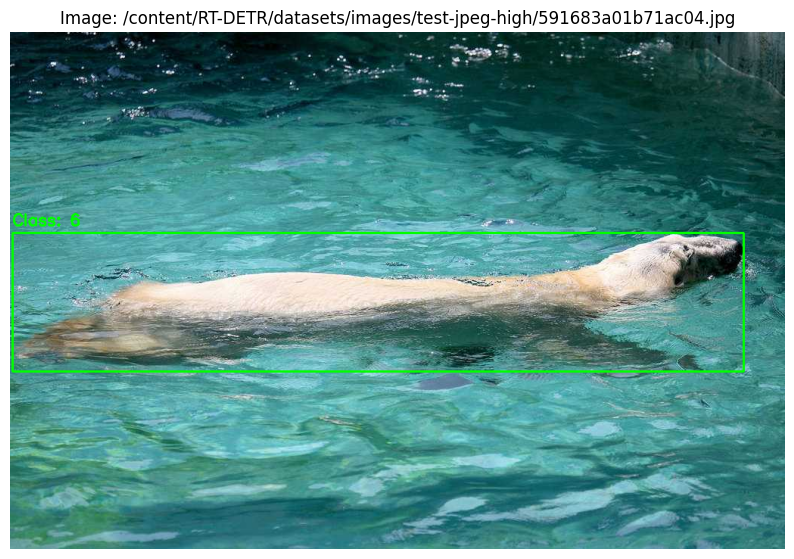

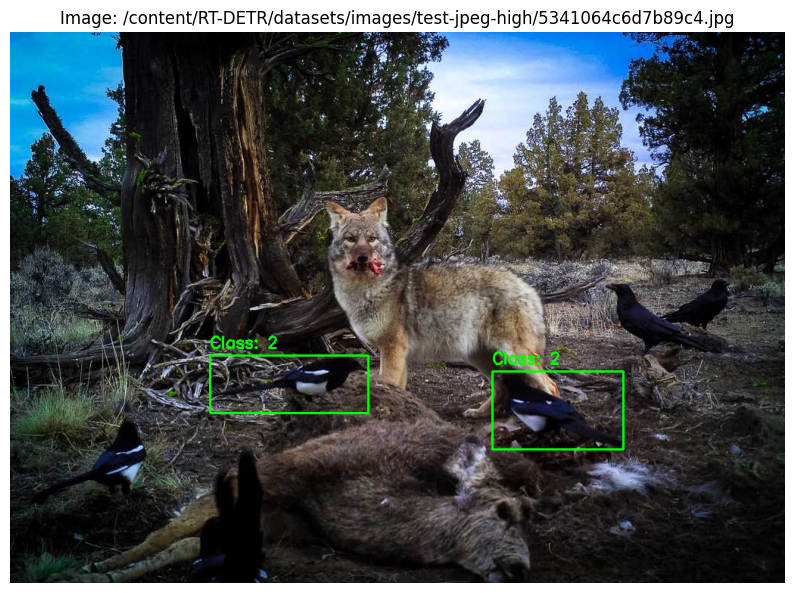

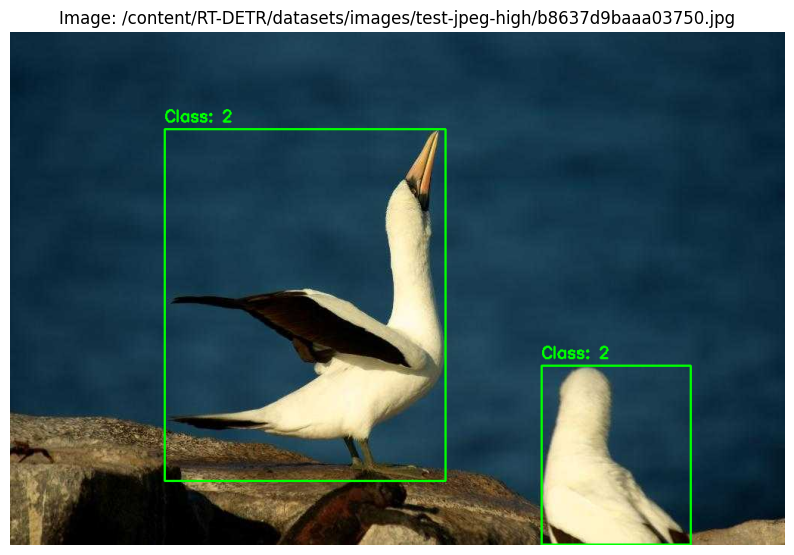

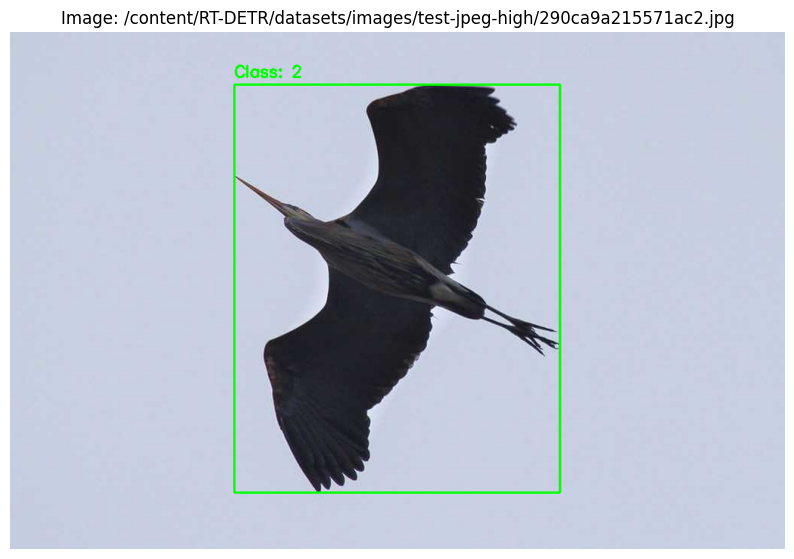

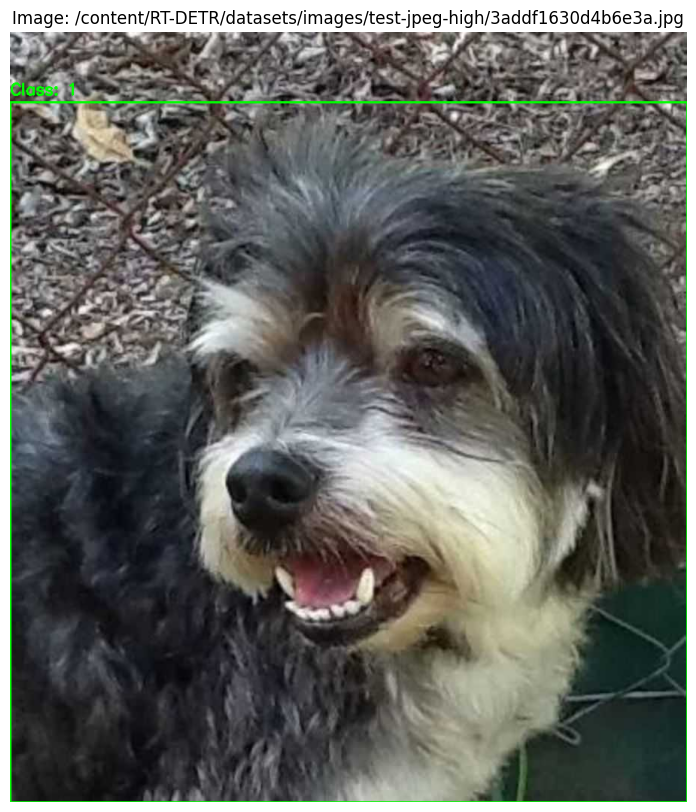

In [ ]:
import cv2
import os
import random
import matplotlib.pyplot as plt

def visualize_yolo_data(image_dir, label_dir, num_to_show):
    # Get a list of all image files
    try:
        all_images = [
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        if not all_images:
            print(f"Error: No images found in {image_dir}")
            return
    except FileNotFoundError:
        print(f"Error: Image directory not found at {image_dir}")
        return

    # Select random images
    selected_images = random.sample(all_images, min(num_to_show, len(all_images)))

    for img_name in selected_images:
        # Load image
        img_path = os.path.join(image_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not read image {img_path}")
            continue

        # Get image dimensions
        img_height, img_width, _ = image.shape

        # Find and read label file
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(label_dir, label_name)

        annotated_image = image.copy()

        if os.path.exists(label_path):
            try:
                with open(label_path, 'r') as f:
                    for line in f.readlines():
                        # Parse the YOLO line: <class_id> <x_center> <y_center> <width> <height>
                        parts = line.strip().split()
                        if len(parts) != 5:
                            print(f"Warning: Skipping malformed line in {label_path}: {line}")
                            continue

                        class_id = parts[0]
                        x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts[1:])

                        # Convert normalized (0-1) coordinates to absolute pixel values
                        x_center = x_center_norm * img_width
                        y_center = y_center_norm * img_height
                        box_width = width_norm * img_width
                        box_height = height_norm * img_height

                        # Convert to bounding box corners (xmin, ymin, xmax, ymax)
                        x_min = int(x_center - (box_width / 2))
                        y_min = int(y_center - (box_height / 2))
                        x_max = int(x_center + (box_width / 2))
                        y_max = int(y_center + (box_height / 2))

                        # Draw bounding box and label
                        # Draw the rectangle
                        cv2.rectangle(annotated_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

                        # Prepare the label text
                        label_text = f"Class: {class_id}"

                        # Put the label text above the box
                        cv2.putText(
                            annotated_image,
                            label_text,
                            (x_min, y_min - 10),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.7, (0, 255, 0), 2
                        )
            except Exception as e:
                print(f"Error reading or processing {label_path}: {e}")

        else:
            print(f"Note: No label file found for {img_name} at {label_path}")

        # Display image
        # Convert BGR (OpenCV's default) to RGB (Matplotlib's default)
        annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 10))
        plt.imshow(annotated_image_rgb)
        plt.title(f"Image: {img_path}")
        plt.axis('off') # Hide axes
        plt.show()


IMAGE_DIR = os.path.join(DATASET_ROOT_LOCAL, "images", "test-jpeg-high")
LABEL_DIR = os.path.join(DATASET_ROOT_LOCAL, "labels", "test")
NUM_TO_SHOW = 5  # How many random to display
# --------------------------

visualize_yolo_data(IMAGE_DIR, LABEL_DIR, NUM_TO_SHOW)

# Training (Fine-Tuning)

In [ ]:
TRAINING_RUN_NAME = 'rtdetr_finetune_run1'

Load pre-trained weights and **start** fine-tuning.

**ONLY RUN THIS CELL TO START FINE-TUNING. To resume from a previous checkpoint, go to next cell.**

In [ ]:
from ultralytics import RTDETR

# Load a pre-trained RT-DETR model
# We use 'rtdetr-l.pt' for the large, pre-trained model
# This is pre-trained on COCO 2017 dataset:
# https://docs.ultralytics.com/models/rtdetr/#what-is-baidus-rt-detr-model-and-how-does-it-work
model = RTDETR('rtdetr-l.pt')

# Start the training!
results = model.train(
    data=YAML_PATH,     # Path to data YAML
    epochs=100,         # Number of epochs
    imgsz=640,          # Image size (640 is standard)
    batch=8,            # Batch size
    project=os.path.join(ROOT_PATH, 'runs'), # Where to save results
    name=TRAINING_RUN_NAME # A specific name for this training run
)

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/RT-DETR/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=rtdetr_finetune_run1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plo

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      1/100      7.15G     0.4368       2.98     0.3467          6        640: 100% ━━━━━━━━━━━━ 982/982 2.4it/s 6:47
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 4.0it/s 14.8s
                   all        951       1298      0.748       0.79      0.799      0.695

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      2/100      7.54G     0.3294     0.9353     0.3334         26        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      2/100      7.54G     0.3897      0.774        0.3          5        640: 100% ━━━━━━━━━━━━ 982/982 2.5it/s 6:27
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.4it/s 11.2s
                   all        951       1298      0.819      0.749      0.795      0.665

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      3/100      7.54G     0.3641     0.7262     0.3024         26        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      3/100      7.54G     0.4247     0.7592     0.3054          6        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.4it/s 11.2s
                   all        951       1298      0.775      0.722       0.73      0.585

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      4/100      7.54G     0.4085      0.751     0.3473         29        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      4/100      7.54G     0.4071       0.77     0.3166         26        640: 6% ╸─────────── 62/982 2.6it/s 24.6s<5:55

**Resume fine-tuning from checkpoint.**

Will need to run this to resume each time Colab crashes/times out...

In [ ]:
from ultralytics import RTDETR

# Load the 'last.pt' checkpoint from your previous run
model = RTDETR(os.path.join(ROOT_PATH, 'runs', TRAINING_RUN_NAME, 'weights/last.pt'))

# Resume the training
results = model.train(
    resume=True,
    # The model automatically loads all previous settings (like data path,
    # epochs, batch size, etc.) from the checkpoint
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/RT-DETR/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     78/100       6.9G     0.2771      0.381     0.1802          6        640: 100% ━━━━━━━━━━━━ 982/982 2.5it/s 6:31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 4.1it/s 14.7s
                   all        951       1298      0.822      0.793      0.823      0.698

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     79/100      7.29G     0.1805     0.3053     0.1898         26        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     79/100      7.36G     0.2602     0.3661      0.174          5        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.4it/s 11.1s
                   all        951       1298      0.826      0.794      0.826      0.701

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     80/100      7.36G     0.2082     0.2859      0.203         26        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     80/100      7.37G      0.288     0.3938     0.1843          6        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.4it/s 11.2s
                   all        951       1298       0.83       0.78       0.82      0.696

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     81/100      7.38G     0.2358     0.3949     0.2269         29        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     81/100      7.48G     0.2876     0.3876     0.1825         10        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.3it/s 11.2s
                   all        951       1298       0.83      0.791      0.826      0.697

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     82/100      7.48G     0.2759     0.4394      0.265         37        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     82/100      7.54G     0.3085     0.3925     0.1897          4        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.4it/s 11.2s
                   all        951       1298      0.843      0.792      0.828       0.69

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     83/100      7.54G     0.2899     0.4158     0.1806         31        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     83/100       7.6G      0.306     0.3916       0.19          8        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.3it/s 11.3s
                   all        951       1298      0.822      0.801      0.822      0.692

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     84/100       7.6G     0.2701     0.4039     0.1569         24        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     84/100      7.61G     0.2833     0.3869     0.1854          7        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.3it/s 11.2s
                   all        951       1298      0.822      0.797       0.82       0.68

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     85/100      7.62G      0.346     0.3379     0.1169         31        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     85/100      7.72G     0.3097     0.3875     0.1894          4        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.4it/s 11.2s
                   all        951       1298      0.824      0.787      0.822      0.678

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     86/100      7.72G     0.1607      0.301     0.1597         16        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     86/100      7.78G     0.3113     0.3957     0.1952          9        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.4it/s 11.2s
                   all        951       1298      0.819      0.796      0.824      0.688

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     87/100      7.78G     0.2214     0.3477     0.1338         31        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     87/100      7.84G     0.2995     0.3863     0.1842          5        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.3it/s 11.3s
                   all        951       1298      0.821      0.798      0.824      0.694

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     88/100      7.84G     0.1775     0.3539     0.1629         18        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     88/100      7.85G     0.3045     0.4021      0.194          8        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.4it/s 11.2s
                   all        951       1298      0.823      0.792      0.823      0.689

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     89/100      7.87G     0.2518     0.4468     0.1737         33        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     89/100      7.96G     0.2861     0.3915     0.1825          3        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.4it/s 11.2s
                   all        951       1298      0.828      0.791      0.824      0.695

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     90/100      7.96G      0.352     0.3997     0.2882         21        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     90/100      8.02G     0.3344     0.4054     0.1993          4        640: 100% ━━━━━━━━━━━━ 982/982 2.5it/s 6:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.3it/s 11.3s
                   all        951       1298       0.82      0.794      0.822      0.694
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     91/100      8.02G     0.7179     0.4613     0.2795         21        640: 0% ──────────── 0/982  0.7s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     91/100      8.08G     0.2738     0.3255     0.1788          3        640: 100% ━━━━━━━━━━━━ 982/982 2.5it/s 6:26
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.3it/s 11.3s
                   all        951       1298       0.83      0.791      0.824      0.693

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     92/100      8.08G     0.1075     0.2167     0.1147          8        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     92/100      8.09G     0.2366     0.3021     0.1603          2        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.4it/s 11.2s
                   all        951       1298      0.833      0.788      0.826      0.697

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     93/100       8.1G     0.5253     0.4621     0.3016         27        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     93/100       8.2G     0.2379     0.2957     0.1589          5        640: 100% ━━━━━━━━━━━━ 982/982 2.5it/s 6:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.3it/s 11.3s
                   all        951       1298      0.834      0.789      0.825      0.701

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     94/100       8.2G     0.2531     0.3764     0.1368         12        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     94/100      8.26G     0.2299     0.2955     0.1538          2        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.4it/s 11.2s
                   all        951       1298      0.823       0.79      0.826      0.697

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     95/100      8.26G     0.1937     0.2699     0.2659         12        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     95/100      8.37G     0.2085     0.2804     0.1457          2        640: 100% ━━━━━━━━━━━━ 982/982 2.5it/s 6:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.3it/s 11.2s
                   all        951       1298      0.822      0.792      0.825      0.702

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     96/100      8.41G      0.293     0.3012     0.2324         11        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     96/100      8.47G     0.2057     0.2738     0.1417         11        640: 100% ━━━━━━━━━━━━ 982/982 2.5it/s 6:26
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.3it/s 11.2s
                   all        951       1298       0.82      0.789      0.823      0.703

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     97/100      8.49G     0.1344     0.3056     0.1432         15        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     97/100      8.63G     0.1978      0.272     0.1384          5        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.3it/s 11.4s
                   all        951       1298      0.812      0.799      0.823      0.704

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     98/100      8.67G      0.124     0.2983     0.1089         10        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     98/100      8.78G     0.1972     0.2655     0.1389          2        640: 100% ━━━━━━━━━━━━ 982/982 2.5it/s 6:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.3it/s 11.2s
                   all        951       1298      0.805      0.798      0.821      0.703

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     99/100      8.78G     0.0992     0.1764     0.1483          9        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     99/100      8.89G     0.1911     0.2639     0.1347          5        640: 100% ━━━━━━━━━━━━ 982/982 2.6it/s 6:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.3it/s 11.3s
                   all        951       1298      0.805      0.803      0.821      0.703

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
    100/100      8.93G       0.13     0.2042     0.1328         11        640: 0% ──────────── 0/982  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    100/100      8.99G       0.19     0.2601     0.1323          2        640: 100% ━━━━━━━━━━━━ 982/982 2.5it/s 6:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 60/60 5.4it/s 11.2s
                   all        951       1298      0.807      0.798      0.822      0.704

23 epochs completed in 2.535 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/colab/RT-DETR/runs/rtdetr_finetune_run1/weights/last.pt, 66.3MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/colab/RT-DETR/runs/rtdetr_finetune_run1/weights/best.pt, 66.3MB

Validating /content/drive/MyDrive/Colab Notebooks/colab/RT-DETR/runs/rtdetr_finetune_run1/weights/best.pt...
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
rt-detr-l summary: 302 layers, 32,002,235 parameters, 0 gradients, 103.5 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━

# Validate the Model on Test Set

In [ ]:
from ultralytics import RTDETR

# Load model
# The best.pt file is saved in the results folder
model = RTDETR(os.path.join(ROOT_PATH, 'runs', TRAINING_RUN_NAME, 'weights/best.pt'))

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
def evaluate_model(model, data_yaml, run_name):
  # Run validation
  # This will use the 'test' set defined in data.yaml
  metrics = model.val(
      data=data_yaml,
      split="test",
      project=os.path.join(ROOT_PATH, 'runs'), # Where to save results
      name=run_name # A specific name for this evaluation run
    )

  # Print the key metrics
  print("mAP50-95:", metrics.box.map)
  print("mAP50:", metrics.box.map50)
  print("mAP75:", metrics.box.map75)
  print()

In [ ]:
# Run validation for each test set
for test_run_name, _, yaml_path in TEST_LIST:
  evaluate_model(model, yaml_path, test_run_name)

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
rt-detr-l summary: 302 layers, 32,002,235 parameters, 0 gradients, 103.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1674.7±462.6 MB/s, size: 439.8 KB)
val: Scanning /content/RT-DETR/datasets/labels/test... 1282 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1282/1282 1.5Kit/s 0.9s
val: /content/RT-DETR/datasets/images/test/0ff037d4305d0f10.jpg: 4 duplicate labels removed
val: /content/RT-DETR/datasets/images/test/194f812bc0f9dceb.jpg: 2 duplicate labels removed
val: /content/RT-DETR/datasets/images/test/2f94dffb2c9da13e.jpg: 9 duplicate labels removed
val: /content/RT-DETR/datasets/images/test/7faa0fcd8e0206d1.jpg: 4 duplicate labels removed
val: /content/RT-DETR/datasets/images/test/8e989aae24d45230.jpg: 2 duplicate labels removed
val: /content/RT-DETR/datasets/images/test/d5a19e615dc779ef.jpg: 2 duplicate labels removed
val: New cache created: /content/RT-DETR/datasets/labels/test.c